In [378]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import pickle

import cv2

# Target Images

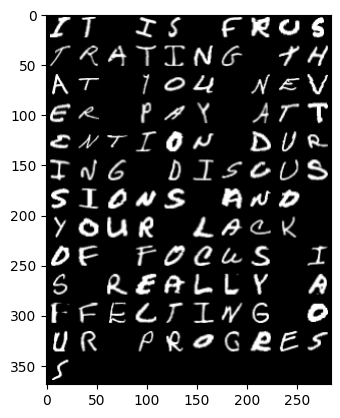

In [379]:

image_path  = '/kaggle/input/target-images/target_images/line_2.png'


image = cv2.imread(image_path,0)

plt.imshow(image,cmap='gray')


# Preprocssing the image

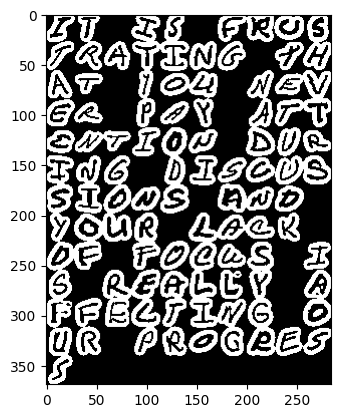

In [260]:
thresh = cv2.adaptiveThreshold(image, 2127, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
plt.imshow(thresh,cmap='gray')

# Character Segmentation

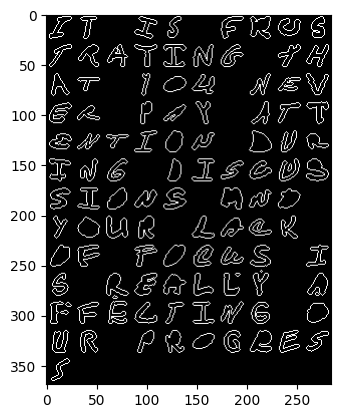

In [262]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
image_internal = np.zeros(image.shape)
internal_contours = []

# Iterate through list of contour arrays
sum = 0
for i in range(len(contours)):
    # If third column value is NOT equal to -1 than its internal
    if hierarchy[0][i][3] != -1:
        
        # Draw the Contour
        sum +=1
        internal_contours.append(contours[i])
        cv2.drawContours(image_internal, contours, i, 255, 1)
        
plt.imshow(image_internal,cmap='gray')

In [263]:
image.shape

(369, 284)

In [264]:
len(internal_contours)

109

In [265]:
def sort_contours_by_y_then_x(contours):
    # Sort contours by y coordinate
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])
    
    # Group contours by y coordinate within a range
    grouped_points = []
    current_group = [cv2.boundingRect(contours[0])[1]]
    
    for i in range(1, len(contours)):
        if cv2.boundingRect(contours[i])[1] - current_group[-1] <= 15:
            current_group.append(cv2.boundingRect(contours[i])[1])
        else:
            grouped_points.append(current_group)
            current_group = [cv2.boundingRect(contours[i])[1]]
    grouped_points.append(current_group)
    
    sorted_contours = []
    
    # Sort each group by x coordinate
    for group in grouped_points:
        list_by_y = [c for c in contours if cv2.boundingRect(c)[1] in group]
        list_sorted_by_x = sorted(list_by_y, key=lambda c: cv2.boundingRect(c)[0])
        sorted_contours.extend(list_sorted_by_x)
    
    return sorted_contours


sorted_contours = sort_contours_by_y_then_x(internal_contours)

In [266]:
len(sorted_contours)

109

In [267]:
area_characters = np.array([cv2.contourArea(contour) for contour in sorted_contours])
print(f'Max Character Area {area_characters.max()}')
print(f'Min Character Area {area_characters.min()}')



Max Character Area 313.5
Min Character Area 2.0


In [268]:
min_contour_area = 80
sorted_contours = [c for c in sorted_contours if cv2.contourArea(c) > min_contour_area]

len(sorted_contours)

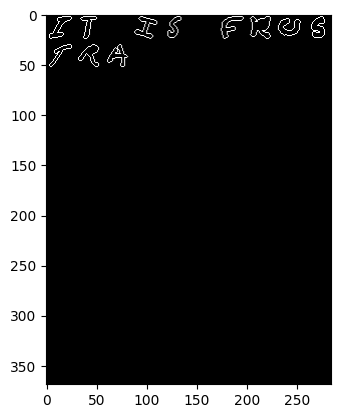

In [269]:
external_contours = np.zeros(image.shape)
for i in range(len(sorted_contours)-90):
  cv2.drawContours(external_contours,sorted_contours,i,255,1)


plt.imshow(external_contours,cmap='gray')

In [394]:
# List to store character images
char_images = []

for contour in sorted_contours:
    # Get the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Extract the character
    char_image = image[y:y+h, x:x+w]

    char_images.append(char_image)
    
len(char_images)

101

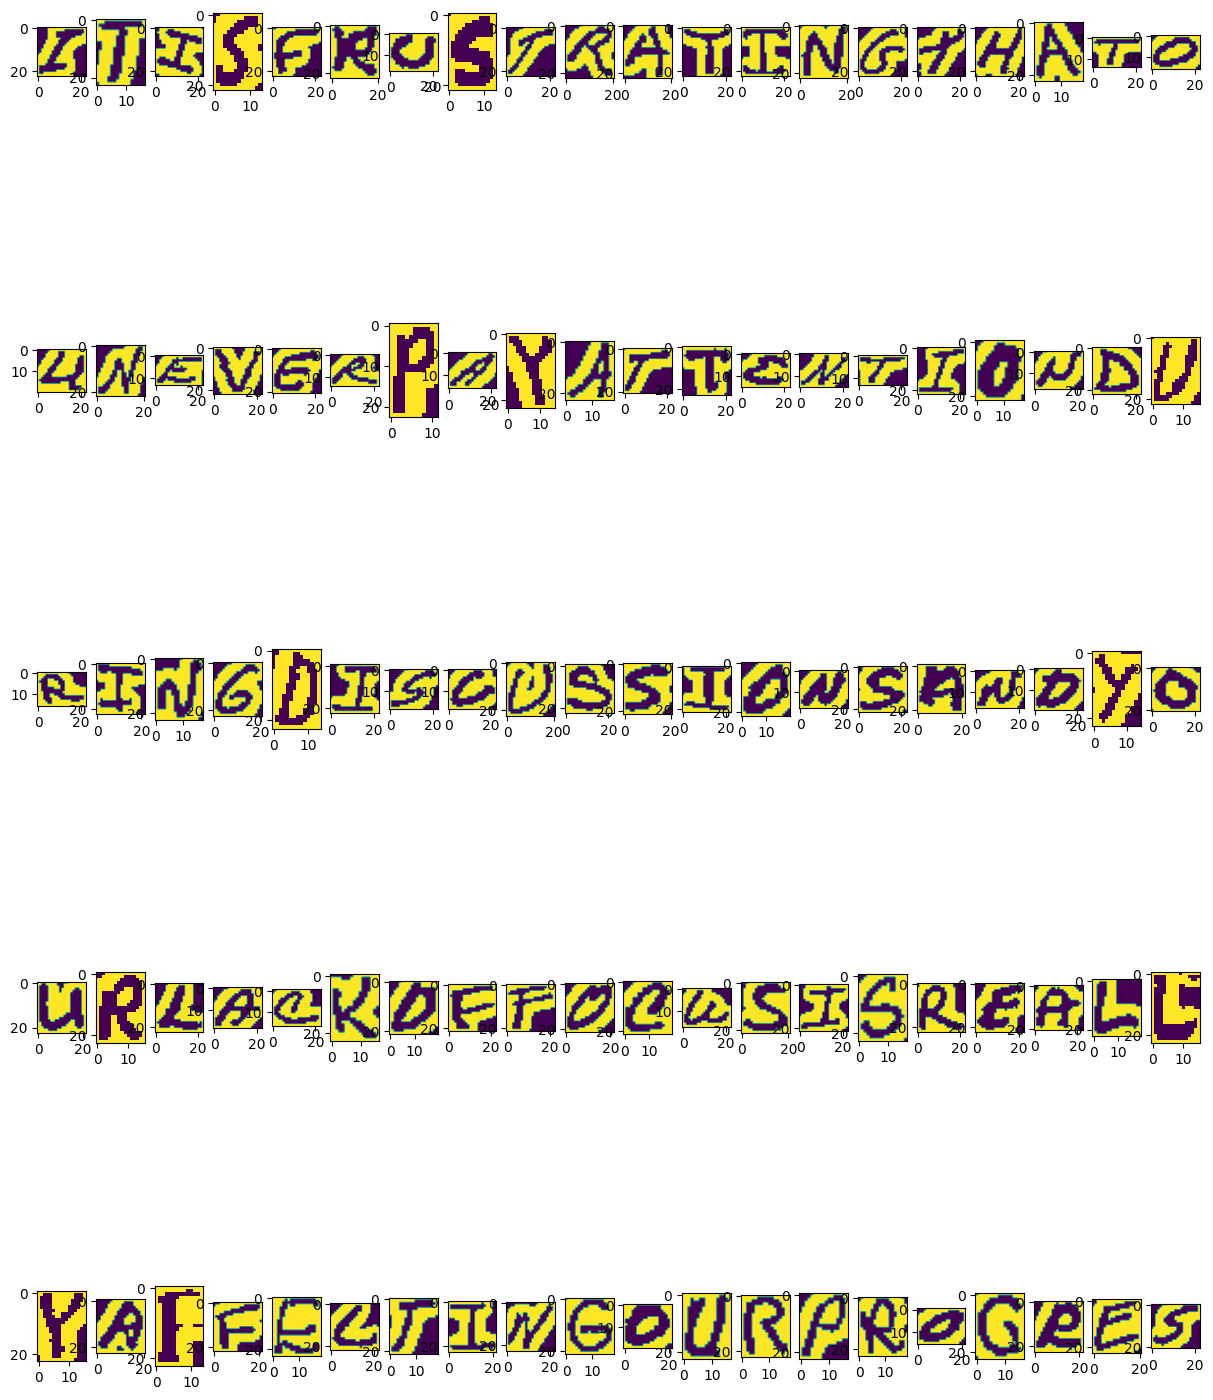

In [390]:

fig,axes = plt.subplots(5,20,figsize=(15,20))


    
for i,ax in enumerate(axes.ravel()):
    ax.imshow(char_images[i])



# Training the model (Alphabet Recogonizer)

In [272]:
data = pd.read_csv('/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv')

In [273]:

data.shape

(372450, 785)

In [274]:
data.columns = ['label'] + [f'pixel_{i}' for i in range(784)]

In [275]:

Y = data.label
X = data.drop('label', axis=1)

In [276]:
Y.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [277]:
letters = [chr(i)  for  i in range(65,91) ]
letters

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

In [279]:
X_train.shape,X_test.shape

((297960, 28, 28, 1), (74490, 28, 28, 1))

In [280]:
X_test[3].shape

(28, 28, 1)

In [281]:

#Model Train


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2,2)))


model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2,2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(26, activation='softmax'))

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        51,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,218 (258.66 KB)

 Trainable params: 66,218 (258.66 KB)

 Non-trainable params: 0 (0.00 B)

In [285]:
pickle.dump(model,open('alphabel_recogonizer.pkl','wb'))

In [286]:
model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

In [287]:

history = model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

Epoch 1/5
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.8415 - loss: 0.7441 - val_accuracy: 0.9732 - val_loss: 0.0957
Epoch 2/5
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9620 - loss: 0.1301 - val_accuracy: 0.9794 - val_loss: 0.0738
Epoch 3/5
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9694 - loss: 0.1067 - val_accuracy: 0.9812 - val_loss: 0.0686
Epoch 4/5
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9720 - loss: 0.0971 - val_accuracy: 0.9812 - val_loss: 0.0685
Epoch 5/5
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9747 - loss: 0.0908 - val_accuracy: 0.9830 - val_loss: 0.0616


In [292]:
y_pred = model.predict(X_test)

2328/2328 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [293]:
print(classification_report(np.argmax(y_pred,axis=1),y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2804
           1       0.96      0.98      0.97      1641
           2       0.99      0.98      0.99      4790
           3       0.97      0.91      0.94      2191
           4       0.99      0.96      0.98      2272
           5       0.86      0.98      0.91       204
           6       0.96      0.98      0.97      1170
           7       0.97      0.94      0.96      1516
           8       0.99      0.97      0.98       241
           9       0.95      0.98      0.97      1621
          10       0.98      0.95      0.96      1175
          11       0.97      0.99      0.98      2274
          12       0.99      0.98      0.99      2522
          13       0.98      0.98      0.98      3759
          14       0.98      0.99      0.99     11468
          15       0.99      1.00      0.99      3837
          16       0.97      0.98      0.98      1150
          17       0.98    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


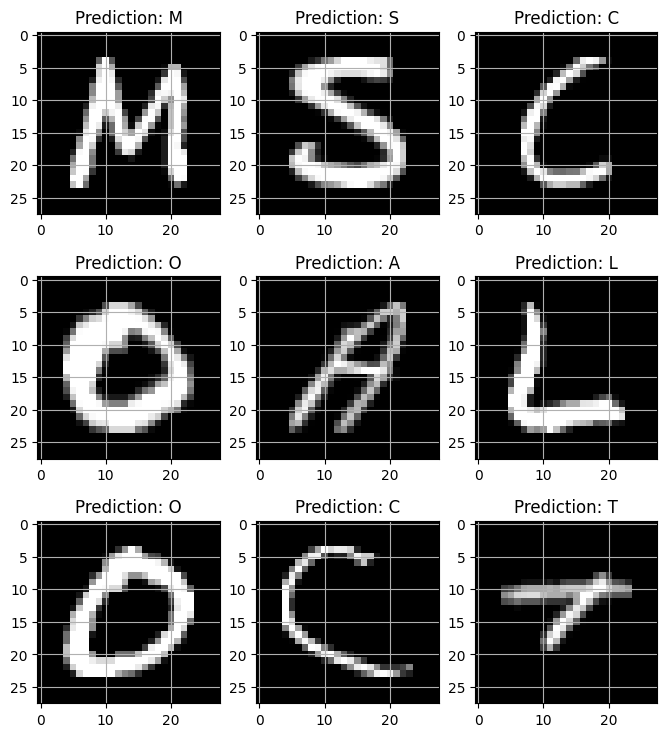

In [294]:
fig, axes = plt.subplots(3,3, figsize=(8,9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    img = X_test[i].reshape(28, 28)  # Reshape to (28, 28) for imshow
    ax.imshow(img, cmap="gray")
    
    # Assuming `letters` is your class labels or something similar
    pred = letters[np.argmax(model.predict(np.expand_dims(X_test[i], 0)), axis=1)[0]]
    ax.set_title("Prediction: " + pred)
    ax.grid()

# Checking the model with external images

In [303]:
test_image_loaded = keras.utils.load_img('/kaggle/input/alphabet-images/test_alphabet_images/image_348292.png' ,color_mode='grayscale')

In [304]:
test_image = np.array(test_image_loaded)
test_image.shape

(106, 93)

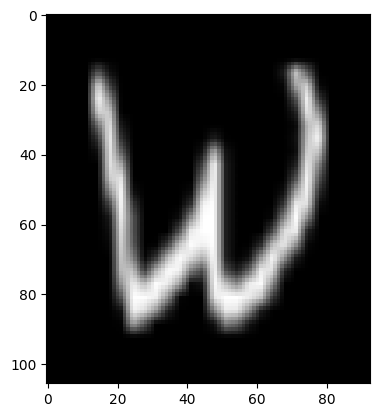

In [305]:
plt.imshow(test_image,'gray')

In [308]:
test_image =cv2.resize(test_image,(28,28))
test_image = np.expand_dims(test_image, -1)
test_image = np.expand_dims(test_image, axis=0) 
test_image.shape

(1, 28, 28, 1)

In [310]:
letters[np.argmax(model.predict(test_image),axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


'W'

# Recogonizing the characters


In [376]:
def preprocess_char_image(char_image):
    
    
#     ret,char_image = cv2.threshold(char_image,.5,1,cv2.THRESH_BINARY)
    char_image = char_image.astype('float32')
    char_image = cv2.resize(char_image, (28, 28),cv2.INTER_CUBIC)
     # Resize to match your model's input size
    char_image = np.expand_dims(char_image, -1)
    char_image = np.expand_dims(char_image, axis=0) 
    
    return char_image



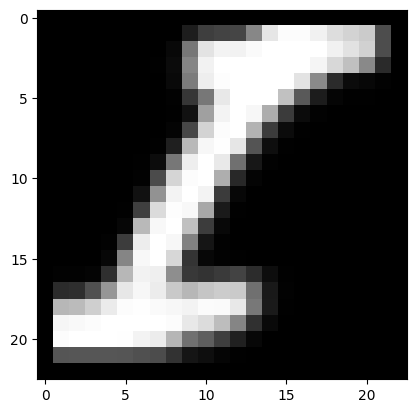

In [398]:
 plt.imshow(char_images[0],cmap ='gray')

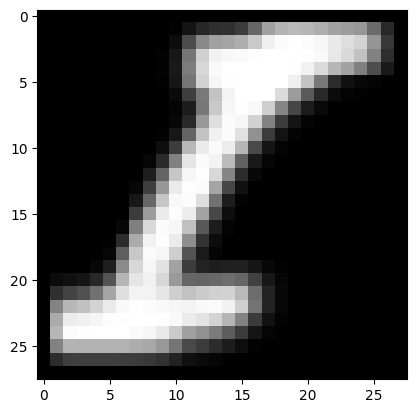

In [399]:
 plt.imshow(preprocess_char_image(char_images[0]).reshape(28,28),cmap='gray')

In [400]:
letters[np.argmax(model.predict(preprocess_char_image(char_images[0])),axis=1)[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


'I'

In [401]:
letters = [chr(i) for i in range(65,91)]

# List to store character images
predicted_characters = []
prev_x= None
space_threshold =14



for contour in sorted_contours:
    # Get the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Extract the character
    char_image = image[y:y+h, x:x+w]
    char_image = preprocess_char_image(char_image)
    
    if prev_x != None and x-prev_x >= space_threshold :
        predicted_characters.append(' ')
        
    
    predicted_characters.append(letters[np.argmax(model.predict(char_image),axis=1)[0]])
    
    prev_x =x+w
    
    

recogonized_text = ''.join(predicted_characters)
recogonized_text

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

'IT IS FRUSTRATJNG THAT OU NEVER PAT ATTENTION DNRING DLSCUSSJONS ANDYOUR LAEKOE TOCUS IS EEALLY APFEZTING OUR PKOCEESS'